## Notebook 2 - Exploring the Data
### sxm4bz
### Ryan Colavita

In this notebook, I explore the singular file that was just created. I also created the WPA metric for the notebook. WPA stands for: Win probability added. It takes a team's chance to win before a player's at-bat and also takes the team's chance to win after a player's at bat and subtracts them. This will tell us if the player had a positive or negative impact on the team's ability to win based off of their performance at the plate. 

After creating the metric, I created many different kinds of plots to explore every aspect of the data. I also filtered the data to show players that have more than 150 plate appearances to filter out some of the players that do not hit as much as others. I also saved a ranking of the players with the best WPA to a file called "clutch_stats_ranked." Each plot is saved as a .png in the same folder as the notebook as well. 

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

FILE_PATH = 'savant_data.csv'
COLUMNS_TO_LOAD = ['player_name', 'events', 'delta_home_win_exp', 'inning_topbot']
data_raw = pd.read_csv(FILE_PATH, usecols=COLUMNS_TO_LOAD, low_memory=False) 

MIN_PLATE_APPEARANCES = 150 
sns.set_style("whitegrid")

data_events = data_raw[
    data_raw['events'].notna() &            
    data_raw['delta_home_win_exp'].notna() & 
    data_raw['player_name'].notna() &
    data_raw['inning_topbot'].notna()
].copy()

data_events['delta_home_win_exp'] = pd.to_numeric(data_events['delta_home_win_exp'], errors='coerce')
data_events.dropna(subset=['delta_home_win_exp'], inplace=True) 

data_events['batter_wpa'] = data_events.apply(
    lambda row: row['delta_home_win_exp'] if row['inning_topbot'] == 'Bot' else -row['delta_home_win_exp'],
    axis=1
)

clutch_stats = data_events.groupby('player_name').agg(
    total_wpa=('batter_wpa', 'sum'),
    plate_appearances=('events', 'count'), # Count of PA-ending events
).reset_index()

clutch_stats_ranked = clutch_stats[
    clutch_stats['plate_appearances'] >= MIN_PLATE_APPEARANCES
].sort_values(by='total_wpa', ascending=False).reset_index(drop=True)

clutch_stats_ranked.to_csv('clutch_stats_ranked.csv', index=False)
print("Aggregated clutch stats saved to 'clutch_stats_ranked.csv' for the next notebook.")

## Visualizations
Note: Some graphs may visualize the same thing, I was experimenting with different kinds of graphs as well.

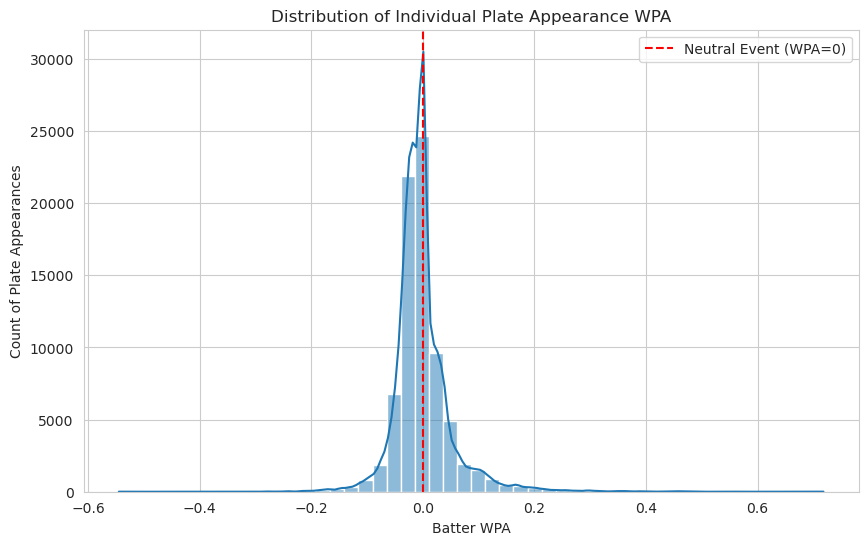

In [7]:
#Graph 1: Distribution of Batter WPA
plt.figure(figsize=(10, 6))
sns.histplot(data_events['batter_wpa'], bins=50, kde=True)
plt.title('Distribution of Individual Plate Appearance WPA')
plt.xlabel('Batter WPA')
plt.ylabel('Count of Plate Appearances')
plt.axvline(0, color='red', linestyle='--', label='Neutral Event (WPA=0)')
plt.legend()
plt.savefig('Exploration_WPA_Distribution.png')
plt.show()

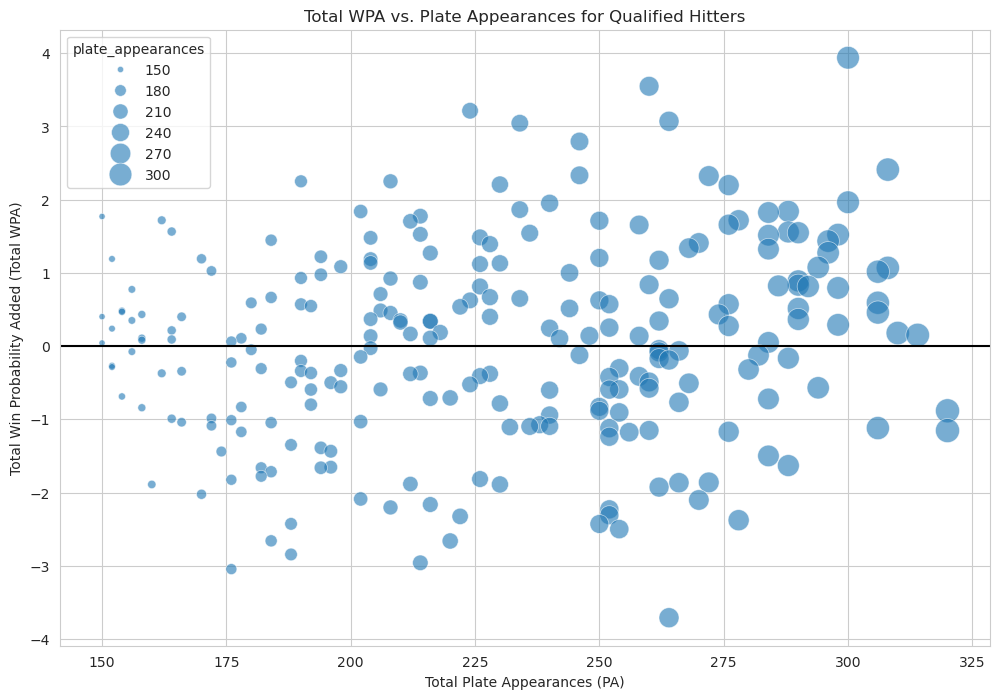

In [8]:
#Graph 2: WPA vs. Plate Appearances
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='plate_appearances', 
    y='total_wpa', 
    data=clutch_stats_ranked, 
    alpha=0.6,
    size='plate_appearances',
    sizes=(20, 300)
)
plt.title('Total WPA vs. Plate Appearances for Qualified Hitters')
plt.xlabel('Total Plate Appearances (PA)')
plt.ylabel('Total Win Probability Added (Total WPA)')
plt.axhline(0, color='black', linestyle='-')
plt.savefig('Exploration_WPA_vs_PA_Scatter.png')
plt.show()

/tmp/ipykernel_143/3630638237.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


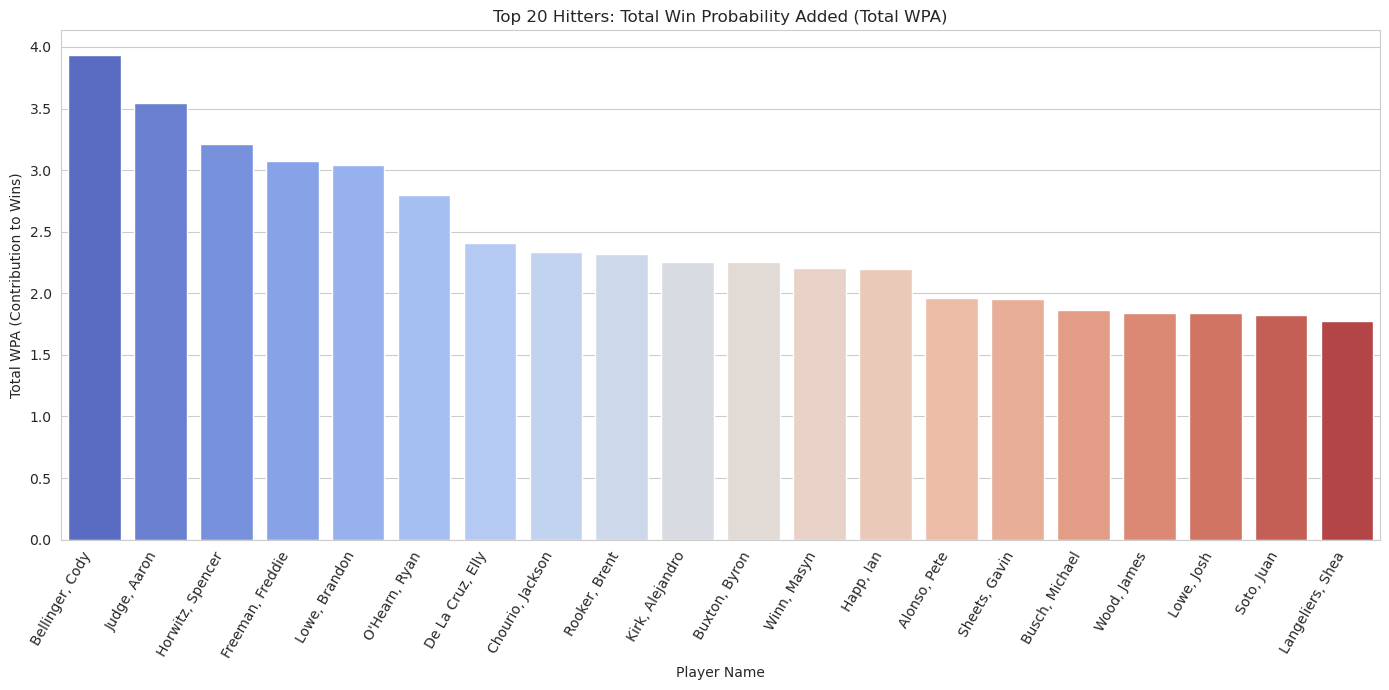

Graph 3: Simple bar chart showing the highest Total WPA values.


In [9]:
#Graph 3: Top 20 Players by Total WPA
top_20 = clutch_stats_ranked.head(20)

plt.figure(figsize=(14, 7))
sns.barplot(
    x='player_name', 
    y='total_wpa', 
    data=top_20, 
    palette=sns.color_palette("coolwarm", 20)
)
plt.title('Top 20 Hitters: Total Win Probability Added (Total WPA)')
plt.xlabel('Player Name')
plt.ylabel('Total WPA (Contribution to Wins)')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.savefig('Exploration_Top20_WPA_Simple_Bar.png')
plt.show()

print("Graph 3: Simple bar chart showing the highest Total WPA values.")

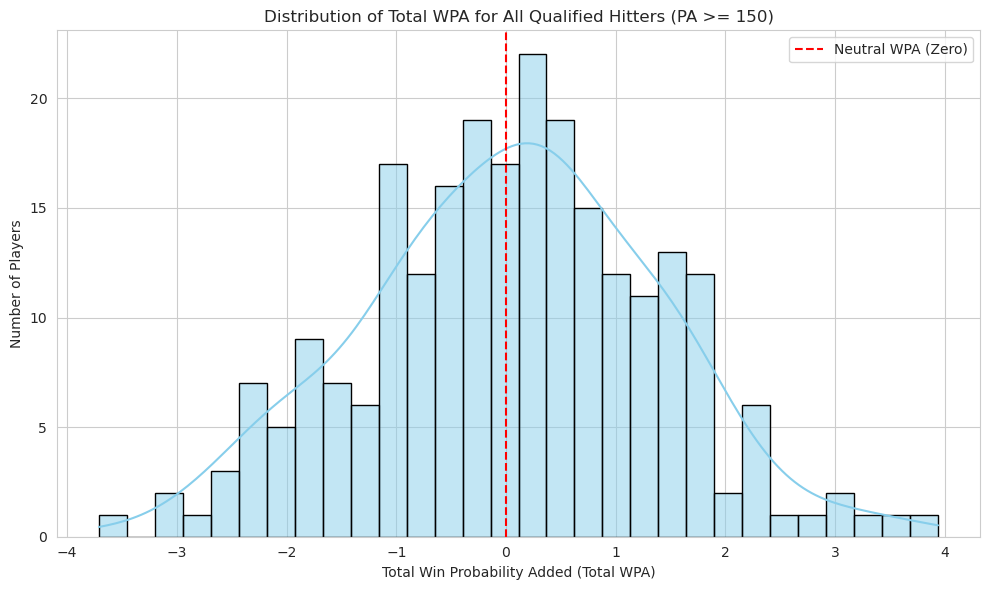

Graph 4: Distribution of Total WPA across the entire pool of qualified hitters.


In [10]:
#Graph 4: Distribution of Total WPA Across All Qualified Players
plt.figure(figsize=(10, 6))
sns.histplot(
    clutch_stats_ranked['total_wpa'], 
    bins=30, 
    kde=True, 
    color='skyblue',
    edgecolor='black'
)
plt.title('Distribution of Total WPA for All Qualified Hitters (PA >= 150)')
plt.xlabel('Total Win Probability Added (Total WPA)')
plt.ylabel('Number of Players')
plt.axvline(0, color='red', linestyle='--', label='Neutral WPA (Zero)')
plt.legend()
plt.tight_layout()
plt.savefig('Exploration_Total_WPA_Distribution.png')
plt.show()

print("Graph 4: Distribution of Total WPA across the entire pool of qualified hitters.")

/tmp/ipykernel_143/235814602.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


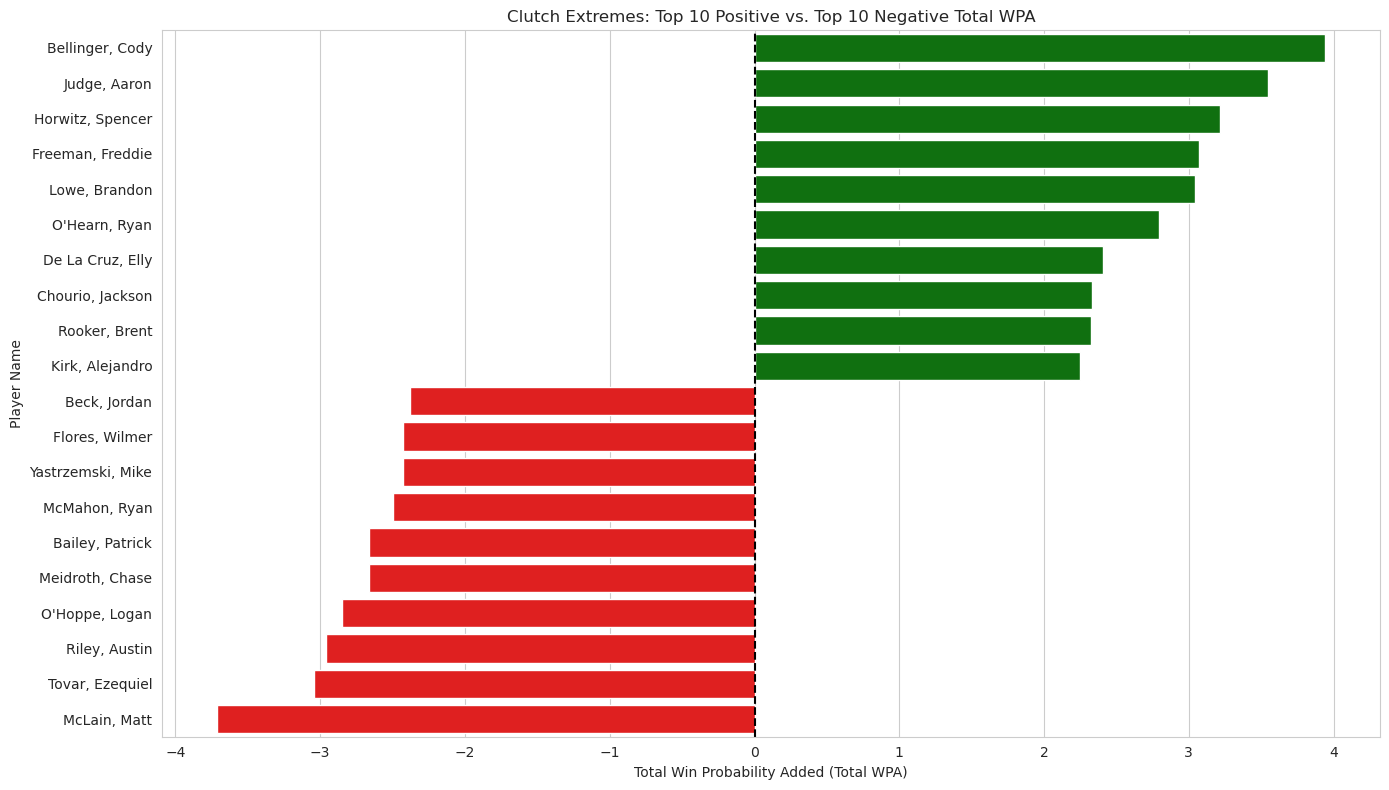

Graph 5: Diverging bar chart comparing the most clutch and anti-clutch players.


In [11]:
#Graph 5: Diverging Bar Chart (Top 10 Positive & Bottom 10 Negative WPA)
top_positive = clutch_stats_ranked.head(10)
bottom_negative = clutch_stats_ranked.tail(10)

clutch_extremes = pd.concat([top_positive, bottom_negative]).sort_values(
    by='total_wpa', ascending=False
).reset_index(drop=True)

clutch_extremes['color'] = clutch_extremes['total_wpa'].apply(
    lambda x: 'green' if x >= 0 else 'red'
)

plt.figure(figsize=(14, 8))
sns.barplot(
    x='total_wpa', 
    y='player_name', 
    data=clutch_extremes, 
    palette=clutch_extremes['color'].tolist(),
    orient='h'
)

plt.title('Clutch Extremes: Top 10 Positive vs. Top 10 Negative Total WPA')
plt.xlabel('Total Win Probability Added (Total WPA)')
plt.ylabel('Player Name')
plt.axvline(0, color='black', linestyle='--')
plt.tight_layout()
plt.savefig('Exploration_Clutch_Extremes_Diverging_Bar.png')
plt.show()

print("Graph 5: Diverging bar chart comparing the most clutch and anti-clutch players.")


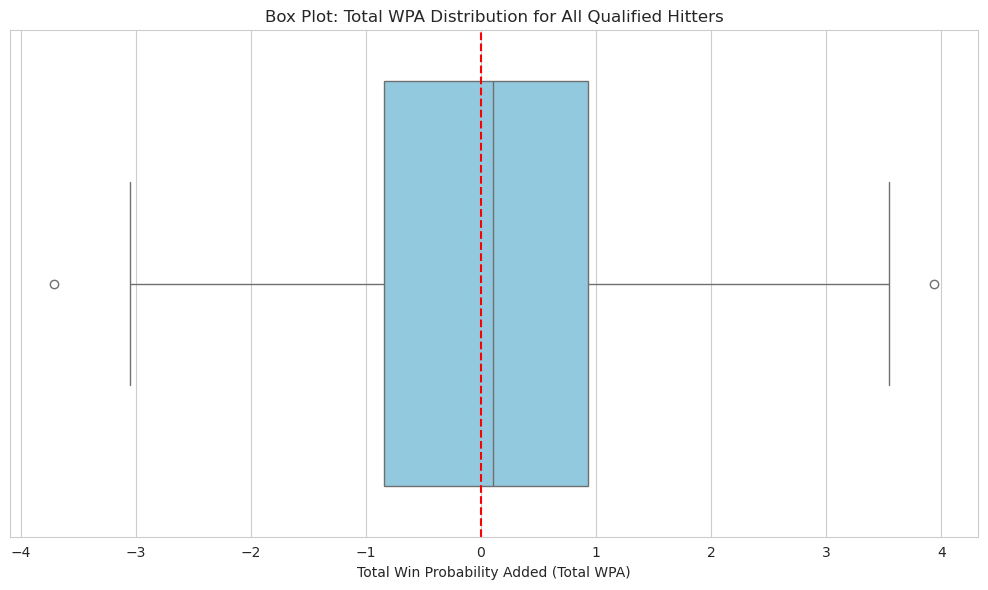


Descriptive Statistics for Total WPA:
|       |   total_wpa |
|:------|------------:|
| count | 241         |
| mean  |   0.0361328 |
| std   |   1.33597   |
| min   |  -3.71      |
| 25%   |  -0.842     |
| 50%   |   0.108     |
| 75%   |   0.93      |
| max   |   3.938     |

Graph 6: Box plot showing the median, quartiles, and range of Total WPA.


In [12]:
#Graph 6: Box Plot of Total WPA Distribution

plt.figure(figsize=(10, 6))
sns.boxplot(
    x=clutch_stats_ranked['total_wpa'], 
    color='skyblue', 
    showfliers=True
)

plt.title('Box Plot: Total WPA Distribution for All Qualified Hitters')
plt.xlabel('Total Win Probability Added (Total WPA)')
plt.axvline(0, color='red', linestyle='--', label='Neutral WPA (Zero)')
plt.tight_layout()
plt.savefig('Exploration_Total_WPA_Box_Plot.png')
plt.show()

wpa_stats = clutch_stats_ranked['total_wpa'].describe().to_markdown()
print("\nDescriptive Statistics for Total WPA:")
print(wpa_stats)
print("\nGraph 6: Box plot showing the median, quartiles, and range of Total WPA.")

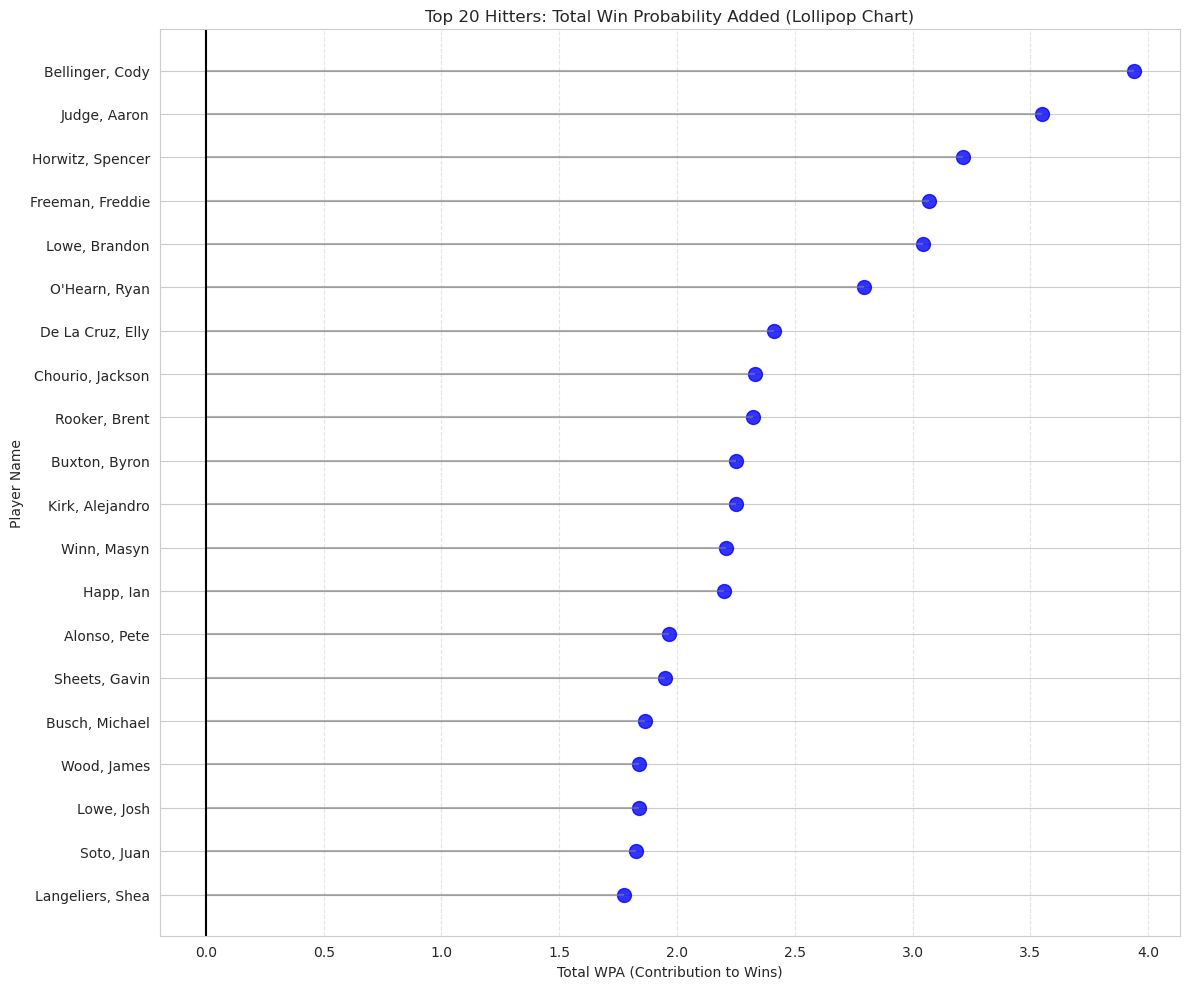

Graph 7: Lollipop chart showing the Total WPA for the top 20 players.


In [13]:
#Graph 7: Lollipop Chart (Top 20 Total WPA)

top_20 = clutch_stats_ranked.head(20).sort_values(by='total_wpa', ascending=True)

plt.figure(figsize=(12, 10))

plt.hlines(
    y=top_20['player_name'], 
    xmin=0, 
    xmax=top_20['total_wpa'], 
    color='gray', 
    alpha=0.6
)

plt.scatter(
    x=top_20['total_wpa'], 
    y=top_20['player_name'], 
    color='blue', 
    s=100, 
    alpha=0.8
)

plt.title('Top 20 Hitters: Total Win Probability Added (Lollipop Chart)')
plt.xlabel('Total WPA (Contribution to Wins)')
plt.ylabel('Player Name')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.axvline(0, color='black', linestyle='-')
plt.tight_layout()
plt.savefig('Exploration_Top20_WPA_Lollipop.png')
plt.show()

print("Graph 7: Lollipop chart showing the Total WPA for the top 20 players.")

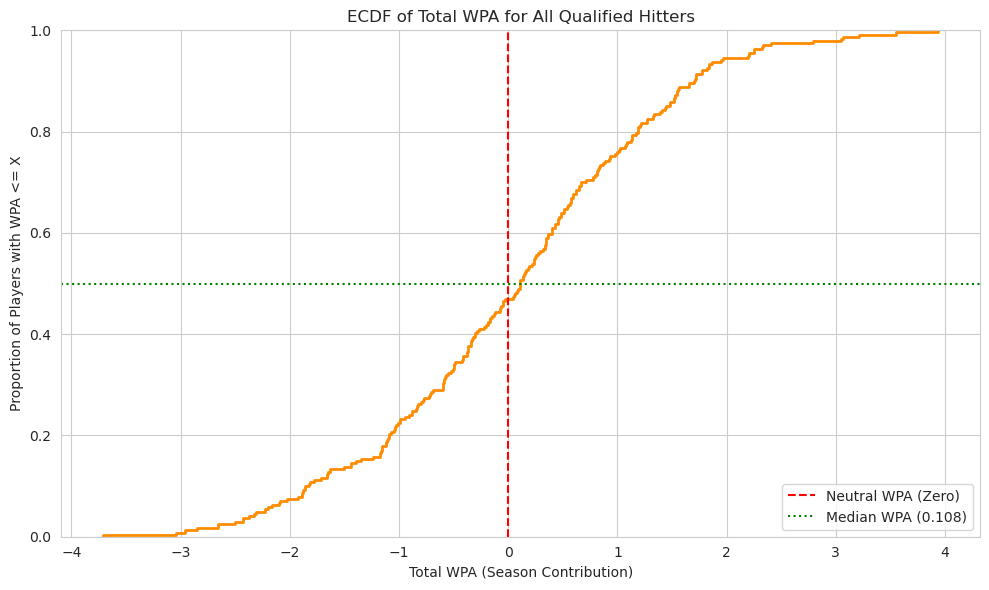

Graph 8: ECDF plot showing the cumulative distribution of Total WPA across the league.


In [14]:
#Graph 8: ECDF Plot of Total WPA Distribution

plt.figure(figsize=(10, 6))

sns.ecdfplot(
    data=clutch_stats_ranked, 
    x='total_wpa', 
    stat='proportion', 
    color='darkorange',
    linewidth=2
)

plt.title('ECDF of Total WPA for All Qualified Hitters')
plt.xlabel('Total WPA (Season Contribution)')
plt.ylabel('Proportion of Players with WPA <= X')

plt.axvline(0, color='red', linestyle='--', label='Neutral WPA (Zero)')

median_wpa = clutch_stats_ranked['total_wpa'].median()
plt.axhline(0.5, color='green', linestyle=':', label=f'Median WPA ({median_wpa:.3f})')

plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('Exploration_Total_WPA_ECDF.png')
plt.show()

print("Graph 8: ECDF plot showing the cumulative distribution of Total WPA across the league.")